# Importation
***

In [12]:
import pandas as pd
import numpy as np
import cv2
import pickle
import seaborn as sns
import os
import keras.constraints
from sklearn.metrics import accuracy_score , confusion_matrix , f1_score
import keras.optimizers
import keras.applications
import keras.layers
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split

# code
***

this function assign each class its index number so the computer can understand it and make its dtype `uint8` for lower memory consumption

In [2]:
def str_to_ind(array):
    cop_array = np.unique(array)
    for i in range(len(array)):
        ind = np.where(cop_array == array[i])[0][0]
        array[i] = ind
    return np.asarray(array , dtype = np.uint8) 

now we load the data from `food1`. i checked the values for each class. we have 21 class with each class has around 800 pics but only 1 class which is `spaghetti` that has around 1600 pics. so i augmented the rest of classes so they contain 1600 pics each. but since my GPU is AMD and i use directML and my tensorflow's version is 2 so im not that from being updated and this is a solved issue which i cant do anything for it. the issue is with training with augmented images. its not optimized so i cant do that so what i did is remove 800 pics from `spaghetti` class so all of them are around 800 pics per class. thats why i made another folder named `food1` and put them all in it. unmodified pic's shape is around (500 , 500) but again my hardware limitations wont allow me to load it at full so i chose half the original size.

In [3]:
ds = []
labels = os.listdir('D:\\datasets\\snap food classifier\\food1\\train')

for label in labels:
    path = os.path.join('D:\\datasets\\snap food classifier\\food1\\train' , label)
    filesINfolder = os.listdir(path)

    for file in filesINfolder:
        pic_path = os.path.join(path , file)
        pic = plt.imread(pic_path)
        resized_pic = cv2.resize(pic , (256 , 256))
        ds.append([resized_pic , label])


and i split things here before make any changes to the dataset

In [ ]:
ds = pd.Series(ds)

train , test = train_test_split(ds , test_size = 0.2)
train , valid = train_test_split(train , test_size = 0.2)

and this code is what i used for augmentation. i used brightness because these are pictures of the foods and people who took them are in resturant and coffee shops and etc so changing brightness is no brainer and i dont expect artistic pics from normal people. i only applied on augmentation because i only wanted a single augmented pic for each pics in each class so the number of pics in each class become double.

In [ ]:
# train = list(train)
# changed_pics = []

# for pic , label in train:
#     if label != 'spaghetti':
#         changed_pic = tf.image.adjust_brightness(pic , -0.27)
#         changed_pics.append([changed_pic , label])

# train = changed_pics + train

and turn them all into ndarray because this dtype is what keras model eats

In [8]:
x_train = np.asarray(list(train[i][0] for i in train.index))
y_train = np.asarray(list(train[i][1] for i in train.index))
y_train = str_to_ind(y_train)

x_test = np.asarray(list(test[i][0] for i in test.index))
y_test = np.asarray(list(test[i][1] for i in test.index))
y_test = str_to_ind(y_test)

x_val = np.asarray(list(valid[i][0] for i in valid.index))
y_val = np.asarray(list(valid[i][1] for i in valid.index))
y_val = str_to_ind(y_val)

this pickle thing is for me not gonna do all those everytime dont mind them

In [2]:
# with open('x_train.pkl' , 'wb') as pickle_out:
#     pickle.dump(x_train , pickle_out)
#     pickle_out.close()

# with open('y_train.pkl' , 'wb') as pickle_out:
#     pickle.dump(y_train , pickle_out)
#     pickle_out.close()

# with open('x_val.pkl' , 'wb') as pickle_out:
#     pickle.dump(x_val , pickle_out)
#     pickle_out.close()

# with open('y_val.pkl' , 'wb') as pickle_out:
#     pickle.dump(y_val , pickle_out)
#     pickle_out.close()

# with open('x_test.pkl' , 'wb') as pickle_out:
#     pickle.dump(x_test , pickle_out)
#     pickle_out.close()

# with open('y_test.pkl' , 'wb') as pickle_out:
#     pickle.dump(y_test , pickle_out)
#     pickle_out.close()

with open('x_train.pkl' , 'rb') as pickle_in:
    x_train = pickle.load(pickle_in)
    pickle_in.close()

with open('y_train.pkl' , 'rb') as pickle_in:
    y_train = pickle.load(pickle_in)
    pickle_in.close()

with open('x_val.pkl' , 'rb') as pickle_in:
    x_val = pickle.load(pickle_in)
    pickle_in.close()

with open('y_val.pkl' , 'rb') as pickle_in:
    y_val = pickle.load(pickle_in)
    pickle_in.close()

with open('x_test.pkl' , 'rb') as pickle_in:
    x_test = pickle.load(pickle_in)
    pickle_in.close()

with open('y_test.pkl' , 'rb') as pickle_in:
    y_test = pickle.load(pickle_in)
    pickle_in.close()

and here i used efficient because i tried it and it worked best! your typical guess game (hyperparameter tuning)

In [3]:
model = keras.applications.EfficientNetB2(input_shape = (256 , 256 , 3) , classes = 21 , include_top = False)
model.trainable = False
flatten = keras.layers.Flatten()(model.layers[-1].output)
dns1 = keras.layers.Dense(128 , activation = 'relu' , kernel_constraint = keras.constraints.max_norm(0.6))(flatten)
drop1 = keras.layers.Dropout(rate = 0)(dns1)
dns2 = keras.layers.Dense(64 , activation = 'relu' , kernel_constraint = keras.constraints.max_norm(0.6))(drop1)
drop2 = keras.layers.Dropout(rate = 0)(dns2)
dns3 = keras.layers.Dense(64 , activation = 'relu' , kernel_constraint = keras.constraints.max_norm(0.6))(drop2)
final = keras.layers.Dense(21 , activation = 'softmax')(dns3)

model = keras.Model(inputs = model.input , outputs = final)
model.compile(loss = 'sparse_categorical_crossentropy' , optimizer = keras.optimizers.Adam(learning_rate = 0.0001) , metrics = ['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 256, 256, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 256, 256, 3)  0           ['normalization[0][0]']      

In [4]:
EarlyStopping = keras.callbacks.EarlyStopping(restore_best_weights = True , monitor = 'val_accuracy' , patience = 3)

In [5]:
history = model.fit(x_train , y_train , validation_data=(x_val , y_val) , batch_size = 32 , epochs = 6 , callbacks = [EarlyStopping])

Epoch 1/6
335/335 [==============================] - 80s 224ms/step - loss: 1.1961 - accuracy: 0.6696 - val_loss: 0.7426 - val_accuracy: 0.7885
Epoch 2/6
335/335 [==============================] - 71s 213ms/step - loss: 0.4317 - accuracy: 0.8864 - val_loss: 0.7023 - val_accuracy: 0.7945
Epoch 3/6
335/335 [==============================] - 71s 213ms/step - loss: 0.2321 - accuracy: 0.9500 - val_loss: 0.7058 - val_accuracy: 0.7844
Epoch 4/6
335/335 [==============================] - 71s 213ms/step - loss: 0.1737 - accuracy: 0.9632 - val_loss: 0.7449 - val_accuracy: 0.7747
Epoch 5/6
335/335 [==============================] - 71s 213ms/step - loss: 0.1614 - accuracy: 0.9618 - val_loss: 0.7282 - val_accuracy: 0.7859


In [ ]:
# model.save('model.h5')
# model = keras.models.load_model('model.h5')

In [6]:
prediction = model.predict(x_test)

105/105 [==============================] - 18s 162ms/step


each prediction give me a probablity for each class. like its 1% spaghetti , 50% ice cream , ... so i need to find index of highest probablity so i used `nanargmax`

In [14]:
res = []
for i in prediction:
    res.append(np.nanargmax(i))

# results
***

all of them are promising and its good.<br> since `f1 score` and `accuracy score` are close we can say we have a good prediction cuz precision and recall are close together and they are both near 80%

In [27]:
f1 = f1_score(y_test , res , average = 'macro')
acc = accuracy_score(y_test , res)
print(f'f1 score: {f1}')
print(f'accuracy score: {acc}')

f1 score: 0.7926204467955329
accuracy score: 0.7928976424947777


<Axes: >

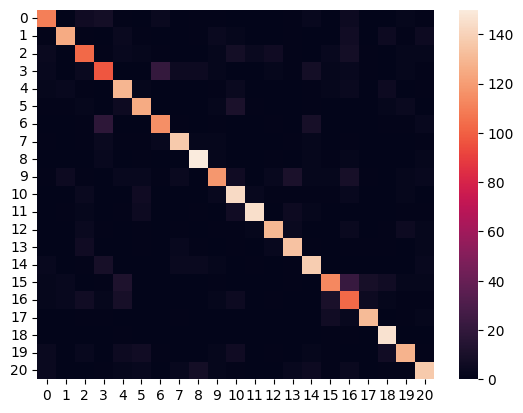

In [28]:
sns.heatmap(confusion_matrix(y_test , res))

<Axes: >

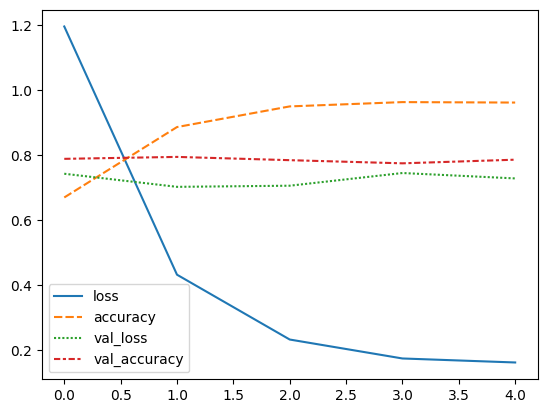

In [11]:
sns.lineplot(history.history)